In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from tensorflow.keras import layers, models, callbacks

In [2]:
np.random.seed(3888)
tf.random.set_seed(3888)

In [8]:
df = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_0.csv")

In [9]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    # 1. mid_price & spread
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread']    = df['ask_price1'] - df['bid_price1']
    
    # 2. imbalance & book_pressure & microprice, shielding their denominators
    with np.errstate(divide='ignore', invalid='ignore'):
        # Level-1 imbalance
        num  = df['bid_size1'] - df['ask_size1']
        den  = df['bid_size1'] + df['ask_size1']
        df['imbalance'] = np.where(den>0, num/den, np.nan)
        
        # Book pressure (L1+L2)
        num2 = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
        den2 = df[['bid_size1','bid_size2','ask_size1','ask_size2']].sum(axis=1)
        df['book_pressure'] = np.where(den2>0, num2/den2, np.nan)
        
        # Microprice
        num3 = (df['ask_price1'] * df['bid_size1'] +
                df['bid_price1'] * df['ask_size1'])
        df['microprice'] = np.where(den>0, num3/den, np.nan)
    
    # 3. normalized_spread & L2 order‐book imbalance
    df['normalized_spread'] = df['spread'] / df['mid_price'].replace(0, np.nan)
    df['OBI_L2'] = np.where(
        den2>0,
        (df['bid_size1'] + df['bid_size2']) / den2,
        np.nan
    )
    
    # 4. entropy of the LOB
    sizes = df[['bid_size1','bid_size2','ask_size1','ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p     = np.divide(sizes, total, where=total!=0)
    entropy = -np.nansum(np.where(p>0, p*np.log(p), 0), axis=1)
    df['LOB_entropy']            = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)
    
    # 5. log returns
    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 5a. realized_volatility over past-30 ticks (no leakage)
    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: 
              np.sqrt((x.shift(1)**2)           # <-- shift here
                       .rolling(window=30, min_periods=1) # window size
                       .sum())
          )
    )

    # 5b. bipower variance over past-30 ticks
    df['bipower_var'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: 
              x.abs()
               .shift(1)                        # only prior returns
               .rolling(2, min_periods=1)
               .apply(lambda r: r[0]*r[1], raw=True)
               .rolling(30, min_periods=1) # window size
               .mean()
          )
    )

    # 5c. integrated variance (sum of squared past returns)

    # df['rolling_integrated_variance'] = (
    #     df.groupby('time_id')['log_return']
    #       .transform(lambda x: 
    #           (x.shift(1)**2)                 # square only past returns
    #             .rolling(window=30, min_periods=1)
    #             .sum()
    #       )
    # )

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df.dropna()
df = make_features(df)

In [10]:
volatility = df['realized_volatility'].values.reshape(-1, 1)
scaler = MinMaxScaler()
volatility_scaled = scaler.fit_transform(volatility).flatten()

In [11]:
SEQ_LEN = 30
def create_dataset(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X)[..., np.newaxis], np.array(y)

X, y = create_dataset(volatility_scaled, SEQ_LEN)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [12]:
def build_transformer_model(seq_len, input_dim=1, d_model=64, num_heads=4, num_layers=2):
    inputs = layers.Input(shape=(seq_len, input_dim))
    
    x = layers.Dense(d_model)(inputs)
    
    for _ in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x1, x1)
        x2 = layers.Add()([x, attention_output])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        ffn_output = layers.Dense(d_model * 4, activation='relu')(x3)
        ffn_output = layers.Dense(d_model)(ffn_output)
        x = layers.Add()([x2, ffn_output])
    
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    output = layers.Dense(1)(x[:, -1, :])
    model = models.Model(inputs, output)
    return model

In [19]:
model = build_transformer_model(SEQ_LEN)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss='mse')
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=2,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1,
                    )

Epoch 1/2
20386/20386 ━━━━━━━━━━━━━━━━━━━━ 389s 19ms/step - loss: 0.0400 - val_loss: 3.7282e-04
Epoch 2/2
20386/20386 ━━━━━━━━━━━━━━━━━━━━ 387s 19ms/step - loss: 2.5621e-04 - val_loss: 1.4599e-04


In [20]:
predictions = model.predict(X_test).flatten()
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

5663/5663 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step


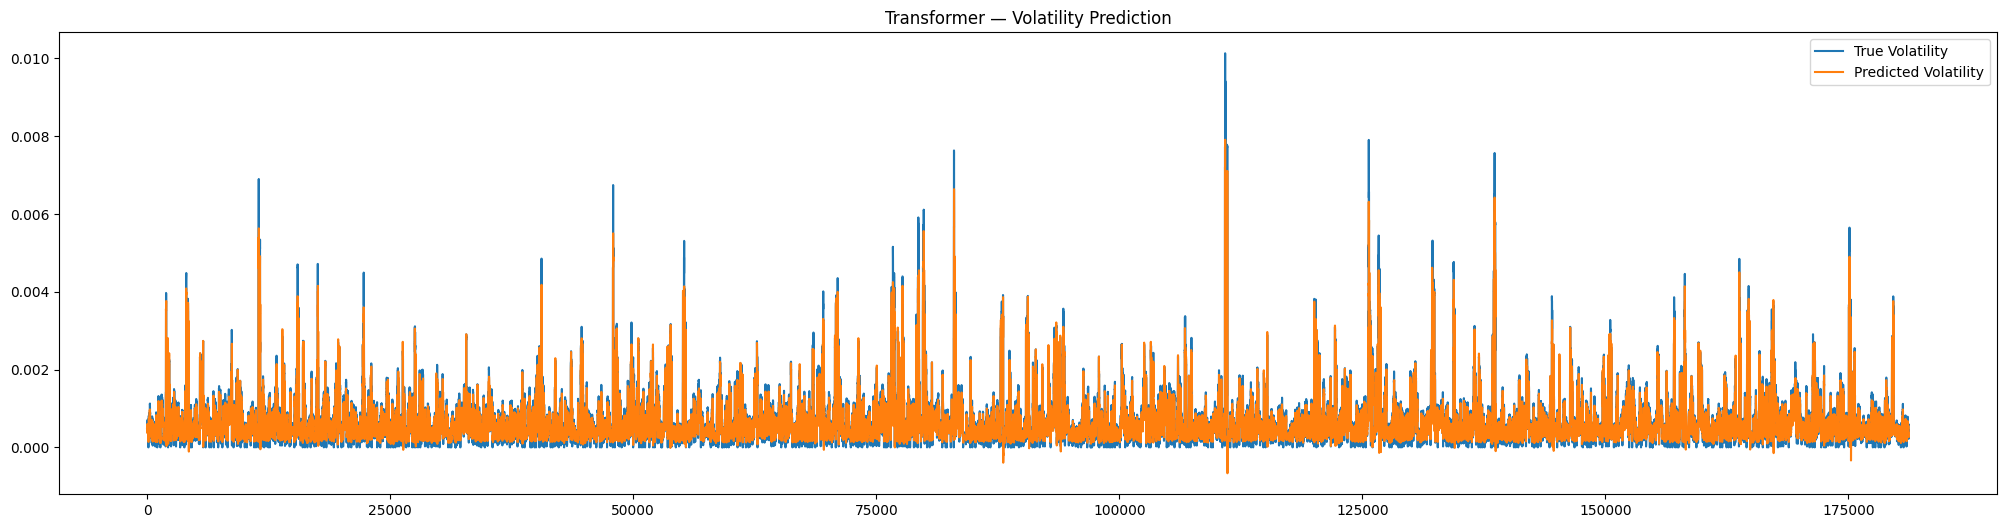

In [24]:
plt.figure(figsize=(25, 6))
plt.plot(actuals, label="True Volatility")
plt.plot(predictions, label="Predicted Volatility")
plt.legend()
plt.title("Transformer — Volatility Prediction")
plt.show()